## Working with Dates

In [1]:
import pandas as pd
from dfply import *
import matplotlib.pylab as plt
%matplotlib inline

## Hiding stack traceback

We hide the exception traceback for didactic reasons (code source: [see this post](https://stackoverflow.com/questions/46222753/how-do-i-suppress-tracebacks-in-jupyter)).  Don't run this cell if you want to see a full traceback.

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

## Data set

We will be using two of the data sets provided by the Museam of Modern Art (MoMA) in this lecture.  Make sure that you have downloaded each repository.  [Download Instructions](./get_MOMA_data.ipynb)

## The exhibition file gives encoding errors by default

In [3]:
exhibitions = pd.read_csv('./data/MoMAExhibitions1929to1989.csv')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 405: invalid continuation byte

## Switching encodings fixes the problem

* See [this Stack Overflow question](https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python)
* More details on [ISO-8859-1](https://en.wikipedia.org/wiki/ISO/IEC_8859-1)

In [ ]:
dat_cols = ['ExhibitionBeginDate', 'ExhibitionEndDate', 'ConstituentBeginDate' ,'ConstituentEndDate']
exhibitions = pd.read_csv('./data/MoMAExhibitions1929to1989.csv', 
                          encoding="ISO-8859-1",
                          parse_dates=dat_cols)
exhibitions.head(2)

,ExhibitionID,ExhibitionNumber,ExhibitionTitle,ExhibitionCitationDate,ExhibitionBeginDate,ExhibitionEndDate,ExhibitionSortOrder,ExhibitionURL,ExhibitionRole,ExhibitionRoleinPressRelease,...,Institution,Nationality,ConstituentBeginDate,ConstituentEndDate,ArtistBio,Gender,VIAFID,WikidataID,ULANID,ConstituentURL
0,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",1929-11-07,1929-12-07,1.0,moma.org/calendar/exhibitions/1767,Curator,Director,...,NaN,American,1902,1981,"American, 19021981",Male,109252853.0,Q711362,500241556.0,moma.org/artists/9168
1,2557.0,1,"Cézanne, Gauguin, Seurat, Van Gogh","[MoMA Exh. #1, November 7-December 7, 1929]",1929-11-07,1929-12-07,1.0,moma.org/calendar/exhibitions/1767,Artist,Artist,...,NaN,French,1839,1906,"French, 18391906",Male,39374836.0,Q35548,500004793.0,moma.org/artists/1053


In [ ]:
(exhibitions >> select(contains('Date'))).dtypes

ExhibitionCitationDate            object
ExhibitionBeginDate       datetime64[ns]
ExhibitionEndDate         datetime64[ns]
ConstituentBeginDate              object
ConstituentEndDate                object
dtype: object

In [ ]:
artists = pd.read_csv("./data/Artists.csv")
artists.head(2)

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN


## Three date types

* **Timestamp** A instant in time.
* **Timedelta** A length of time.
* **Timeinterval** A window of time.

#### `datetime` columns are timestamps

In [ ]:
exhibitions.ExhibitionBeginDate.head(2)

0   1929-11-07
1   1929-11-07
Name: ExhibitionBeginDate, dtype: datetime64[ns]

#### Subtracting dates produces a `timedelta` column

In [ ]:
(exhibitions.ExhibitionEndDate - exhibitions.ExhibitionBeginDate).head(2)

0   30 days
1   30 days
dtype: timedelta64[ns]

#### `Timedelta`s are also created with `pd.Timedelta` and `pd.offsets`

In [ ]:
pd.Timedelta(pd.offsets.Minute(15))

Timedelta('0 days 00:15:00')

In [ ]:
pd.Timedelta(pd.offsets.Hour(120))

Timedelta('5 days 00:00:00')

In [ ]:
pd.Timedelta(pd.offsets.Day(365))

Timedelta('365 days 00:00:00')

#### Creating a time `period`

More information about Python [strftime(format)](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

In [ ]:
exhibitions.ExhibitionBeginDate.dt.to_period('w').head(2)

0    1929-11-04/1929-11-10
1    1929-11-04/1929-11-10
Name: ExhibitionBeginDate, dtype: period[W-SUN]

# Working with Dates

In [ ]:
import pandas as pd
from dfply import *
import matplotlib.pylab as plt
%matplotlib inline

## Outline

* Working with dates.
* Working with text columns.
* Getting started with regular expressions.

## Working with dates

* Pandas is great with dates!
* Converting
* Getting dateparts
* Windows and more

## Example - Uber pickup

The following data represent all Uber pickups in New York City in April 2014.  Find the data and more information at [this repository](https://github.com/fivethirtyeight/uber-tlc-foil-response).

In [ ]:
names = ['date', 'lat', 'lon', 'base']
dates = ['date']
uber_april = pd.read_csv("./data/uber-raw-data-apr14-sample.csv",
                            names=names, header=0,
                            parse_dates=dates)
uber_april.head()

,date,lat,lon,base
0,2014-04-18 21:38:00,40.7359,-73.9852,B02682
1,2014-04-23 15:19:00,40.7642,-73.9543,B02598
2,2014-04-10 07:15:00,40.7138,-74.0103,B02598
3,2014-04-11 15:23:00,40.7847,-73.9698,B02682
4,2014-04-07 17:26:00,40.6460,-73.7767,B02598


##  Datetime utility functions

The most important helper functions live in the `dt` attribute.  Some examples follow

In [ ]:
[m for m in dir(uber_april.date.dt) if not m.startswith('_')]

['ceil',
 'date',
 'day',
 'day_name',
 'day_of_week',
 'day_of_year',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'floor',
 'freq',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'isocalendar',
 'microsecond',
 'minute',
 'month',
 'month_name',
 'nanosecond',
 'normalize',
 'quarter',
 'round',
 'second',
 'strftime',
 'time',
 'timetz',
 'to_period',
 'to_pydatetime',
 'tz',
 'tz_convert',
 'tz_localize',
 'week',
 'weekday',
 'weekofyear',
 'year']

In [ ]:
len([m for m in dir(uber_april.date.dt) if not m.startswith('_')])

42

In [ ]:
uber_april.date.dt.day_name()

0           Friday
1        Wednesday
2         Thursday
3           Friday
4           Monday
           ...    
99995     Saturday
99996       Friday
99997       Friday
99998       Friday
99999       Friday
Name: date, Length: 100000, dtype: object

## Extracting dateparts

* Primary/typical transformation
* Pandas provides datepart attributes

In [ ]:
(uber_april
 >> mutate(hour = uber_april.date.dt.hour,
           day = uber_april.date.dt.day,
           dayofweek = uber_april.date.dt.dayofweek,
           month = uber_april.date.dt.month,
           year = uber_april.date.dt.year,
           weekday_name = uber_april.date.dt.day_name())
 >> head)

,date,lat,lon,base,hour,day,dayofweek,month,year,weekday_name
0,2014-04-18 21:38:00,40.7359,-73.9852,B02682,21,18,4,4,2014,Friday
1,2014-04-23 15:19:00,40.7642,-73.9543,B02598,15,23,2,4,2014,Wednesday
2,2014-04-10 07:15:00,40.7138,-74.0103,B02598,7,10,3,4,2014,Thursday
3,2014-04-11 15:23:00,40.7847,-73.9698,B02682,15,11,4,4,2014,Friday
4,2014-04-07 17:26:00,40.6460,-73.7767,B02598,17,7,0,4,2014,Monday


## Exploring datepart distributions

* Important step in understanding patterns
* Makes it possible to find errors

## Weekday frequency ordered by frequency

In [ ]:
uber_april.date.dt.day_name().value_counts()

Wednesday    19154
Tuesday      16171
Friday       15930
Thursday     15277
Saturday     13569
Monday       10882
Sunday        9017
Name: date, dtype: int64

<AxesSubplot:>

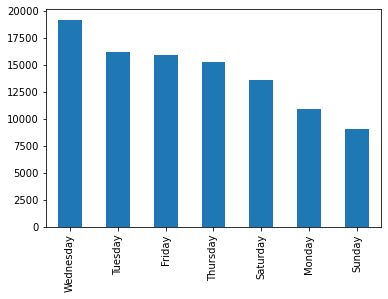

In [ ]:
uber_april.date.dt.day_name().value_counts().plot(kind='bar')

## Weekday ordered chronologically

<AxesSubplot:>

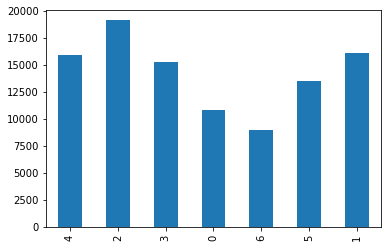

In [ ]:
uber_april.date.dt.dayofweek.value_counts(sort=False).plot(kind='bar')

## <font color="red"> Exercise 3.2.1 </font>

Explore the distributions of rides by hour and minute

<AxesSubplot:>

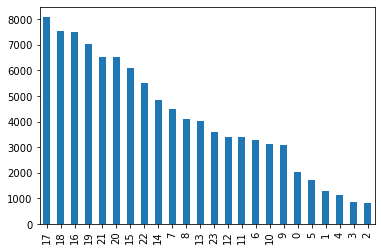

In [ ]:
(uber_april
 .date
 .dt
 .hour
 .value_counts()
 .plot(kind='bar'))

<AxesSubplot:>

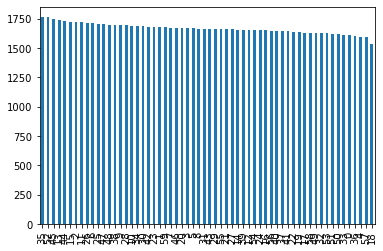

In [ ]:
(uber_april
 .date
 .dt
 .minute
 .value_counts()
 .plot(kind='bar'))

## Representing a duration of time with `timedelta`

In addition to representing time and dates using the `datetime` `dtype`, pandas also as a type designed to represent the difference between two times/dates.

We will use the [NYC Citi Bike System data](https://ride.citibikenyc.com/system-data) to illustrate.

#### Download and unzip some bike data

# (uber_april
 .date
 .dt
 .hour
 .value_counts()
 .plot(kind='bar'))

In [4]:
!wget 'https://s3.amazonaws.com/tripdata/JC-202207-citbike-tripdata.csv.zip' -P ./data
!unzip -o ./data/JC-202207-citbike-tripdata.csv.zip -d ./data
!rm ./data/JC-202207-citbike-tripdata.csv.zip

--2022-09-21 09:39:55--  https://s3.amazonaws.com/tripdata/JC-202207-citbike-tripdata.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.170.224
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.170.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3244301 (3.1M) [application/zip]
Saving to: ‘./data/JC-202207-citbike-tripdata.csv.zip’

JC-202207-citbike-t 100%[===================>]   3.09M  2.57MB/s    in 1.2s    

2022-09-21 09:39:56 (2.57 MB/s) - ‘./data/JC-202207-citbike-tripdata.csv.zip’ saved [3244301/3244301]

Archive:  ./data/JC-202207-citbike-tripdata.csv.zip
  inflating: ./data/JC-202207-citbike-tripdata.csv  
  inflating: ./data/__MACOSX/._JC-202207-citbike-tripdata.csv  


#### Read the data into a dataframe while parsing the two date columns

In [5]:
dates = ['started_at', 'ended_at']
bike_data = pd.read_csv('./data/JC-202207-citbike-tripdata.csv', parse_dates=dates)
bike_data.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,89CDCE3224502904,classic_bike,2022-07-21 18:19:45,2022-07-21 18:28:21,Marshall St & 2 St,HB408,8 St & Washington St,HB603,40.740802,-74.042521,40.745984,-74.028199,member
1,3E6E50F51BD4CBD9,electric_bike,2022-07-21 17:50:57,2022-07-21 17:59:17,Marshall St & 2 St,HB408,11 St & Washington St,HB502,40.740802,-74.042521,40.749985,-74.027150,casual


In [6]:
(bike_data
 >> select(dates)
).dtypes

started_at    datetime64[ns]
ended_at      datetime64[ns]
dtype: object

## Creating a `timedelta` column by subtracting dates

We can compute the duration of each bike trip by subtracting the start and end times.  Note that the resulting column has the `timedelta` dtype.

In [7]:
bike_data_w_delta = (bike_data
                     >> select(dates)
                     >> mutate(duration = X.ended_at - X.started_at)
                    )
bike_data_w_delta.head(2)

,started_at,ended_at,duration
0,2022-07-21 18:19:45,2022-07-21 18:28:21,0 days 00:08:36
1,2022-07-21 17:50:57,2022-07-21 17:59:17,0 days 00:08:20


In [8]:
bike_data_w_delta.dtypes

started_at     datetime64[ns]
ended_at       datetime64[ns]
duration      timedelta64[ns]
dtype: object

### Methods for timedelta are accessed from the `dt` attribute

Similar to the date-parts extracted from a `datetime` column, we can access `timedelta` functions using `dt`.

In [9]:
[m for m in dir(bike_data_w_delta.duration.dt) if not m.startswith('_')]

['ceil',
 'components',
 'days',
 'floor',
 'freq',
 'microseconds',
 'nanoseconds',
 'round',
 'seconds',
 'to_pytimedelta',
 'total_seconds']

#### Various date-parts can be accessed using `dt.components`

In [10]:
bike_data_w_delta.duration.dt.components.head(2)

,days,hours,minutes,seconds,milliseconds,microseconds,nanoseconds
0,0,0,8,36,0,0,0
1,0,0,8,20,0,0,0


####  `dt.components` is a dataframe!

In [11]:
bike_data_w_delta.duration.dt.components.minutes.head(2)

0    8
1    8
Name: minutes, dtype: int64

In [12]:
(bike_data_w_delta.duration.dt.components
 >> select('minutes', 'seconds')
 >> head(2))

,minutes,seconds
0,8,36
1,8,20


#### Total trip duration using `dt.seconds` and `dt.days`

In [13]:
bike_data_w_delta.duration.dt.seconds.head(2) #Rounded down to closest second

0    516
1    500
Name: duration, dtype: int64

In [14]:
bike_data_w_delta.duration.dt.days.head(2) #Rounded down to closest day

0    0
1    0
Name: duration, dtype: int64

## <font color="red"> Exercise 3.2.2 </font>

Further explore the `dt` methods for the `timedelta` dtype using `dir` and `help`.  Report on what you learned.

In [38]:
help(bike_data_w_delta.duration.dt.to_pytimedelta)

Help on method to_pytimedelta in module pandas.core.indexes.accessors:

to_pytimedelta() -> 'np.ndarray' method of pandas.core.indexes.accessors.TimedeltaProperties instance
    Return an array of native :class:`datetime.timedelta` objects.
    
    Python's standard `datetime` library uses a different representation
    timedelta's. This method converts a Series of pandas Timedeltas
    to `datetime.timedelta` format with the same length as the original
    Series.
    
    Returns
    -------
    numpy.ndarray
        Array of 1D containing data with `datetime.timedelta` type.
    
    See Also
    --------
    datetime.timedelta : A duration expressing the difference
        between two date, time, or datetime.
    
    Examples
    --------
    >>> s = pd.Series(pd.to_timedelta(np.arange(5), unit="d"))
    >>> s
    0   0 days
    1   1 days
    2   2 days
    3   3 days
    4   4 days
    dtype: timedelta64[ns]
    
    >>> s.dt.to_pytimedelta()
    array([datetime.timedelta(0), d

to_pytimedelta returns a ine dimension array displaying the diff between 2 date, time, or datetime

## Example -- Plotting the trip duration by weekday

In [ ]:
from calendar import day_name

weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)

day_and_duration = (bike_data_w_delta
                    >> mutate(day_of_week = X.started_at.dt.day_name().astype(weekday_categories),
                              duration_in_min = X.duration.dt.seconds/60)
                    >> select('day_of_week', 'duration_in_min')
                   )
day_and_duration.head(2)

In [ ]:
import seaborn as sns

sns.boxplot(data = day_and_duration,
            x = 'day_of_week',
            y = 'duration_in_min')

## <font color="red"> Exercise 3.2.3 </font>

Suppose that we define a *short trip* as one that lasts less then 1 hour.  Recreate the last visualization, but this time restricting the data to short trips.

In [ ]:
# Your code here

## Classifying days as business day, holiday, or weekend.

For data such as the Uber data, it would be interesting to compare the number of rides depending on if the day was a business/work day, holiday, or on the weekend.  We can use the `workalendar` library to add in classifying the days,

In [ ]:
!pip install workalendar

In [ ]:
from datetime import date
from workalendar.usa import NewYork
cal = NewYork()

#### Getting the dates of all holidays in 2014

In [ ]:
cal.holidays(2014)

#### Checking for holidays or work days

In [ ]:
cal.is_holiday(date(2014, 4, 1))

In [ ]:
cal.is_working_day(date(2014,4,1))

#### Making a classification function

In [ ]:
classify_day = lambda d: "Holiday" if cal.is_holiday(d) else "Work Day" if cal.is_working_day(d) else "Weekend"
uber_april.date.apply(classify_day).head(2)

In [ ]:
(uber_april
 >> mutate(day_type = X.date.apply(classify_day))
 >> group_by('day_type', 'date')
 >> summarise(count = n(X.date))
)

## <font color="red"> Exercise 3.2.4 </font>

Further explore the relationship between of number of rides and the type of day by

1. Plotting the total number of rides for each type of day.
2. Plotting the average number of rides for each type of day.
3. Discussing which of the plots leads to a more fair comparison.

**Hint.** You will need to perform one or more grouped aggregation.

In [ ]:
# Your code for plot 1 here

In [ ]:
# Your code for plot 2 here

You thoughts here

# Pandas specific date tricks

`pandas` has rich set of functions for working with dates, which includes

* `Series` types of ranges of dates.
* Date offset objects, including finding the next business day, holiday, extra.
* The ability to index, slice, and resample time series data.

Details can be found [in the pandas documentation on working with dates and time series](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#)